# Project: 3-Year Recidivism for Offenders Released from Iowa Prison
#### Iowa Correctional System - https://data.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

## Module2: Modelling and Prediction

There are two types of problems defined with this project. One is to find whether or not the offender would commit another crime in a three year period and return to prison. Another one would be to find the offense done by the returned offender.

### Goal of Binary Classification Problem

This dataset reports whether an offender is re-admitted to prison or not within three years from being released from prison in Iowa. In our classification model we want to predict whether an imaginery offender who has a Release Type, Race - Ethnicity, Age At Release, Sex, Offense Classification, Offense Type, Offense Subtype, Days to Return, Recidivism Type and Target Population would have commited another crime and return to prison in a three year period. This is a binary classification problem. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.metrics import roc_curve

In [2]:
# Read csv file to dataframe
df = pd.read_csv('offender_classification.csv', index_col=0) 

#### Training and Testing dataset

In [3]:
# Names of different columns
categorical_cols = list(df.columns)
categorical_cols.remove('return_to_prison')
# Removed due to Data leakage
categorical_cols.remove('recidivism_type') 

continuous_cols = []

predictor_cols = categorical_cols + continuous_cols
target_col = "return_to_prison"

# Split dataset to train and test datasets
X=df[predictor_cols]
y=df[target_col]

X_train, X_test, y_train, y_test = train_test_split(df[predictor_cols], y, random_state=0)

#### Project Pipeline Transformers

In [4]:
# Pipeline for project models
num_transformer = Pipeline(steps=[('impute', SimpleImputer(strategy='mean'))
                                 ,('scale', MinMaxScaler())])

cat_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent'))
                                 ,('enc', OneHotEncoder(sparse = False, handle_unknown='ignore'
                                                        ,dtype=np.int32))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, continuous_cols),
                                           ('cat', cat_transformer, categorical_cols)]
                             ,remainder='passthrough')

#### Modeling Function

In [5]:
def createModel(algorithm):
    # Create model using pipeline
    pipe = Pipeline(steps=[('preprocess', preprocessor)
                            ,('rgr', algorithm)])

    pipe.fit(X_train, y_train)

    # Scores
    score_train = pipe.score(X_train, y_train)
    score_test = pipe.score(X_test, y_test)
    
    return score_train, score_test, pipe

#### Modeling with KNN, SVC and RFC

In [6]:
# K Nearest Neighbors (KNN) model using pipeline
knn_train, knn_test, pipe_knn = createModel(KNeighborsClassifier(n_neighbors=3))

# Support Vector Classifier (SVC) model using pipeline
svc_train, svc_test, pipe_svc = createModel(SVC(kernel='linear'))

# Random Forest Classifier (RFC) model using pipeline
rfc_train, rfc_test, pipe_rfc = createModel(RandomForestClassifier(n_estimators=100))


#### Confusion Matrix Measures

In [7]:
def getMatrixMeasures(pred):
    return "%0.3f   " % accuracy_score(y_test, pred), "%0.3f " % recall_score(y_test, pred, pos_label="Yes"), "%0.3f    " % precision_score(y_test, pred, pos_label="Yes"), "%0.3f    " % fbeta_score(y_test, pred, beta=1, pos_label="Yes")



#### Result Comparison

In [8]:
# Scores
print("--Classification Model Scores--")
print(tabulate([['Training', knn_train, svc_train, rfc_train], 
                ['Testing', knn_test, svc_test, rfc_test]], 
        headers=['Dataset', 'KNN Score', 'SVC Score', 'RFC Score']))

print("\n")
# Confusion matrix measures
print("--Confusion matrix measures--")
print(tabulate([['KNN', getMatrixMeasures(pipe_knn.predict(X_test))],
                ['SVC', getMatrixMeasures(pipe_svc.predict(X_test))],
                ['RFC', getMatrixMeasures(pipe_rfc.predict(X_test))]], 
        headers=['Model', ('Accuracy', 'Recall', 'Precision', 'f-measure')]))

print("\n")
# Test the model
print("--Model Predictions--")
print(tabulate([['Test1', list(y_test.head(1)), pipe_knn.predict(X_test.head(1)), pipe_svc.predict(X_test.head(1)), pipe_rfc.predict(X_test.head(1))], 
                ['Test2', list(y_test.tail(1)), pipe_knn.predict(X_test.tail(1)), pipe_svc.predict(X_test.tail(1)), pipe_rfc.predict(X_test.tail(1))]], 
        headers=['Prediction', 'Actual', 'KNN', 'SVC', 'RFC']))


--Classification Model Scores--
Dataset      KNN Score    SVC Score    RFC Score
---------  -----------  -----------  -----------
Training      0.74927      0.608533     0.856506
Testing       0.565937     0.590998     0.586861


--Confusion matrix measures--
Model    ('Accuracy', 'Recall', 'Precision', 'f-measure')
-------  --------------------------------------------------
KNN      ('0.566   ', '0.445 ', '0.467    ', '0.456    ')
SVC      ('0.591   ', '0.130 ', '0.495    ', '0.206    ')
RFC      ('0.587   ', '0.410 ', '0.492    ', '0.448    ')


--Model Predictions--
Prediction    Actual    KNN      SVC      RFC
------------  --------  -------  -------  -------
Test1         ['Yes']   ['Yes']  ['No']   ['Yes']
Test2         ['No']    ['Yes']  ['Yes']  ['No']


#### Summary

Based on the f-measure, it looks like KNN is a better approach for predicting Recidivism. Given below is the ROC curve related to RNN 

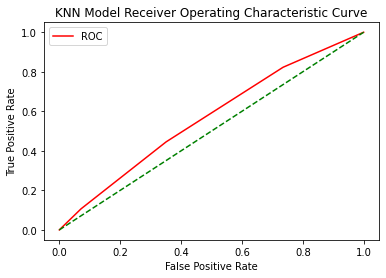

In [9]:
def plot_roc_curve(model, fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model + ' Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = pipe_knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, prob, pos_label="Yes")
plot_roc_curve('KNN Model', fpr, tpr)


### Goal of Second Classification Problem

This dataset reports whether an offender is re-admitted to prison or not within three years from being released from prison in Iowa. In our second classification model we want to predict the offense of an imaginery offender who would have commited another crime and returned to prison in a three year period. 

In [10]:
# Read file
df_yes = pd.read_csv('recidivism_types.csv', index_col=0) 

# Names of different columns
categorical_cols = list(df_yes.columns)
categorical_cols.remove('new_offensesub_type')

# Removing Data Leakage
categorical_cols.remove('new_offenseclassification')
categorical_cols.remove('new_offensetype')

continuous_cols = []

predictor_cols = categorical_cols + continuous_cols
target_col = "new_offensesub_type"

# Split dataset to train and test datasets
X=df_yes[predictor_cols]
y=df_yes[target_col]

X_train, X_test, y_train, y_test = train_test_split(df_yes[predictor_cols], y, random_state=0)

# Pipeline for project models
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, continuous_cols),
                                           ('cat', cat_transformer, categorical_cols)]
                             ,remainder='passthrough')

# K Nearest Neighbors (KNN) model using pipeline
knn_train, knn_test, pipe_knn = createModel(KNeighborsClassifier(n_neighbors=3))

# Support Vector Classifier (SVC) model using pipeline
svc_train, svc_test, pipe_svc = createModel(SVC(kernel='linear'))

# Random Forest Classifier (RFC) model using pipeline
rfc_train, rfc_test, pipe_rfc = createModel(RandomForestClassifier(n_estimators=100))


# Scores
print("--Classification Model Scores--")
print(tabulate([['Training', knn_train, svc_train, rfc_train], 
                ['Testing', knn_test, svc_test, rfc_test]], 
        headers=['Dataset', 'KNN Score', 'SVC Score', 'RFC Score']))

print("\n")
# Test the model
print("--Model Predictions--")
print(tabulate([['Test1', list(y_test.head(1)), pipe_knn.predict(X_test.head(1)), pipe_svc.predict(X_test.head(1)), pipe_rfc.predict(X_test.head(1))], 
                ['Test2', list(y_test.tail(1)), pipe_knn.predict(X_test.tail(1)), pipe_svc.predict(X_test.tail(1)), pipe_rfc.predict(X_test.tail(1))]], 
        headers=['Prediction', 'Actual', 'KNN', 'SVC', 'RFC']))


--Classification Model Scores--
Dataset      KNN Score    SVC Score    RFC Score
---------  -----------  -----------  -----------
Training      0.607185     0.641127     0.999008
Testing       0.392262     0.475        0.464286


--Model Predictions--
Prediction    Actual              KNN                 SVC                 RFC
------------  ------------------  ------------------  ------------------  ------------------
Test1         ['Other Criminal']  ['Other Criminal']  ['Other Criminal']  ['Other Criminal']
Test2         ['Theft']           ['Alcohol']         ['Other Criminal']  ['Burglary']
